# Company Bankruptcy Prediction `2`

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score, precision_score, recall_score, roc_auc_score 

from sklearn.feature_selection import SelectFromModel, mutual_info_classif, f_classif, SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = pd.read_csv('Company Bankruptcy Prediction.csv')
# remove leading and trailing white space in column name
ds.columns = [i.title().strip() for i in list(ds.columns)]
# print shape of dataset
ds.shape

(6819, 96)

## Data Sampling

In [3]:
X = ds.drop('Bankrupt?', axis=1)
y = ds['Bankrupt?']

In [4]:
#Traditional split of the dataset 80% - 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

In [5]:
#Proportional split of 80% data with respect to the class of the target feature ie. [1,0]
sf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [6]:
for train_index, test_index in sf.split(x_train, y_train):
    sf_x_train, sf_x_test = X.iloc[train_index], X.iloc[test_index]
    sf_y_train, sf_y_test = y.iloc[train_index], y.iloc[test_index]

    # sf_x_train, sf_x_test, sf_y_train, sf_y_test = sf_x_train.values, sf_x_test.values, sf_y_train.values, sf_y_test.values

In [7]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
sel_.fit(sf_x_train, sf_y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [8]:
selected_feat = X.columns[sel_.get_support()]
# selected_feat


In [9]:
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 95
selected features: 13
features with coefficients shrank to zero: 58


In [10]:
removed_feats = x_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
# removed_feats = removed_feats.to_list()

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_sc = sc.fit_transform(sf_x_train)
x_train_sc = pd.DataFrame(x_train_sc , columns=sf_x_train.columns, index=sf_x_train.index)

x_test_sc = sc.transform(sf_x_test)
x_test_sc = pd.DataFrame(sf_x_test, columns=sf_x_test.columns, index=sf_x_test.index)

In [12]:
x_train_sc.drop(removed_feats, axis=1, inplace=True)
x_test_sc.drop(removed_feats, axis=1, inplace=True)


### PCA visualization

In [13]:
from sklearn.decomposition import PCA
pc = PCA(n_components=len(x_train_sc.columns))
x_train_pc = pc.fit_transform(x_train_sc)
PC_df_train = pd.DataFrame(x_train_pc,columns=['PC_' +str(i) for i in range(1,pc.n_components_+1)])

In [14]:
PC_df_train

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37
0,4.261830,0.664941,-0.844727,0.144340,-0.445447,0.128803,-0.034242,-0.058916,0.368899,0.000971,...,-0.755200,0.502127,0.903241,1.029109,-0.027012,-0.105594,1.012245,0.234903,-0.128136,3.815218e-17
1,2.439572,-2.311366,-0.284996,-0.529601,0.668149,-0.454465,0.050279,-0.172165,-0.456187,1.118869,...,-0.243173,0.009102,0.194536,0.718992,-0.139471,0.072763,0.516976,0.008184,-0.197717,-8.147003e-17
2,3.650678,-0.254314,0.137801,1.021435,1.738948,4.485028,-3.254555,-0.350655,-0.182066,-0.281888,...,1.412873,-0.409036,-0.374005,-0.214190,-0.443037,-0.110089,-0.548775,-0.582105,-0.141893,-1.731144e-16
3,3.540328,-1.218777,-0.650979,-0.024538,-0.846657,-0.131419,-0.042510,-0.078053,0.690761,0.103643,...,0.534552,-0.986677,-0.195534,-0.870762,-0.305272,-0.529568,-0.439273,0.467492,-0.222883,-4.145539e-17
4,0.604262,0.983673,-1.791991,0.651401,-1.210239,0.398357,-0.345031,-0.268971,1.227049,-0.068110,...,-0.595818,0.700042,0.489328,-0.731244,0.620279,-0.002896,0.244801,-0.161327,-0.264801,-5.361976e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4359,-0.382911,1.120284,2.018966,-0.319267,-0.193378,-0.057464,-0.193427,-0.142446,0.436196,0.365228,...,-0.361966,0.403036,0.316010,-0.497408,0.185972,0.136069,0.331024,-0.160635,-0.147292,8.015471e-17
4360,-1.825613,0.999562,-2.220198,-0.401268,0.570962,-0.347244,-0.277889,-0.230729,0.575783,-0.439659,...,0.088500,0.758970,-0.417755,1.403949,0.075616,0.515151,0.147752,-0.071139,0.113205,-1.711672e-17
4361,2.709371,2.419938,1.238457,0.927245,-0.662217,-0.071183,0.114743,0.415117,1.274750,-4.162461,...,0.524236,0.993124,0.688256,0.039316,0.700752,0.614565,-0.015486,0.702692,-0.143362,-6.339330e-17
4362,2.948462,1.872506,-0.085342,-0.827604,0.142251,-0.606456,0.166592,-0.204019,-0.712670,-1.202256,...,-0.670035,-0.682125,1.190165,0.143265,-0.185092,0.017865,0.157939,0.307376,-0.160332,-2.458525e-17


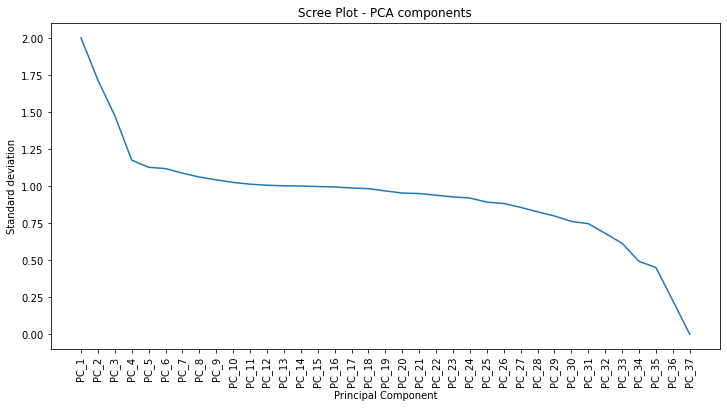

In [15]:
plt.figure(figsize=(12,6))
plt.plot(PC_df_train.std())
plt.title('Scree Plot - PCA components')
plt.xlabel('Principal Component')
plt.xticks(rotation=90)
plt.ylabel('Standard deviation')
plt.show()

In [16]:
pc = PCA(n_components=8)
X_train_pc=pc.fit_transform(x_train_sc)
PC_df_train=pd.DataFrame(X_train_pc,columns=['PC_' +str(i) for i in range(1,pc.n_components_+1)])

In [17]:
X_test_pc = pc.transform(x_test_sc)
PC_df_test=pd.DataFrame(X_test_pc,columns=['PC_' +str(i) for i in range(1,pc.n_components_+1)])

In [18]:
print(PC_df_train.shape)
y_train.shape

(4364, 8)


(5455,)

## Logistic Regression Model

In [19]:
classifier_lr = LogisticRegression()
classifier_lr.fit(PC_df_train,sf_y_train)
y_lr = classifier_lr.predict(X_test_pc)

print('Confusion Matrix \n',confusion_matrix(y_lr,sf_y_test))
print()
print('Accuracy Score \n', accuracy_score(y_lr,sf_y_test))
print()
print('Classification Report \n',classification_report(y_lr,sf_y_test))

Confusion Matrix 
 [[  14    0]
 [1060   17]]

Accuracy Score 
 0.02841429880843263

Classification Report 
               precision    recall  f1-score   support

           0       0.01      1.00      0.03        14
           1       1.00      0.02      0.03      1077

    accuracy                           0.03      1091
   macro avg       0.51      0.51      0.03      1091
weighted avg       0.99      0.03      0.03      1091



In [20]:
classifier_lr_2 = LogisticRegression()
classifier_lr_2.fit(x_train,y_train)
y_lr_2 = classifier_lr_2.predict(x_test)

print('Confusion Matrix \n',confusion_matrix(y_lr_2,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_lr_2,y_test))
print()
print('Classification Report \n',classification_report(y_lr_2,y_test))

Confusion Matrix 
 [[1311   51]
 [   2    0]]

Accuracy Score 
 0.9611436950146628

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1362
           1       0.00      0.00      0.00         2

    accuracy                           0.96      1364
   macro avg       0.50      0.48      0.49      1364
weighted avg       1.00      0.96      0.98      1364



## SVM

In [21]:
classifier_svc = SVC()
classifier_svc.fit(pc.fit_transform(x_train_sc),sf_y_train)
y_svc=classifier_svc.predict(X_test_pc)

print('Confusion Matrix \n',confusion_matrix(y_svc,sf_y_test))
print()
print('Accuracy Score \n', accuracy_score(y_svc,sf_y_test))
print()
print('Classification Report \n',classification_report(y_svc,sf_y_test))

Confusion Matrix 
 [[1074   17]
 [   0    0]]

Accuracy Score 
 0.9844179651695693

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1091
           1       0.00      0.00      0.00         0

    accuracy                           0.98      1091
   macro avg       0.50      0.49      0.50      1091
weighted avg       1.00      0.98      0.99      1091



In [22]:
classifier_svc_2 = LogisticRegression()
classifier_svc_2.fit(x_train,y_train)
y_svc_2 = classifier_svc_2.predict(x_test)

print('Confusion Matrix \n',confusion_matrix(y_svc_2,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_svc_2,y_test))
print()
print('Classification Report \n',classification_report(y_svc_2,y_test))

Confusion Matrix 
 [[1311   51]
 [   2    0]]

Accuracy Score 
 0.9611436950146628

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1362
           1       0.00      0.00      0.00         2

    accuracy                           0.96      1364
   macro avg       0.50      0.48      0.49      1364
weighted avg       1.00      0.96      0.98      1364



## Random Forset Regeression

In [23]:
classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train_pc,sf_y_train)
y_rfc=classifier_rf.predict(X_test_pc)

print('Confusion Matrix \n',confusion_matrix(y_rfc,sf_y_test))
print()
print('Accuracy Score \n', accuracy_score(y_rfc,sf_y_test))
print()
print('Classification Report \n',classification_report(y_rfc,sf_y_test))

Confusion Matrix 
 [[871  10]
 [203   7]]

Accuracy Score 
 0.8047662694775435

Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       881
           1       0.41      0.03      0.06       210

    accuracy                           0.80      1091
   macro avg       0.61      0.51      0.48      1091
weighted avg       0.73      0.80      0.73      1091



## XGB

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train_pc,sf_y_train)
y_gbc=classifier.predict(X_test_pc)

print('Confusion Matrix \n',confusion_matrix(y_gbc,sf_y_test))
print()
print('Accuracy Score \n', accuracy_score(y_gbc,sf_y_test))
print()
print('Classification Report \n',classification_report(y_gbc,sf_y_test))

Confusion Matrix 
 [[687   8]
 [387   9]]

Accuracy Score 
 0.6379468377635197

Classification Report 
               precision    recall  f1-score   support

           0       0.64      0.99      0.78       695
           1       0.53      0.02      0.04       396

    accuracy                           0.64      1091
   macro avg       0.58      0.51      0.41      1091
weighted avg       0.60      0.64      0.51      1091



`2`

In [25]:
classifier_xgb_2 = LogisticRegression()
classifier_xgb_2.fit(x_train,y_train)
y_xgb_2 = classifier_xgb_2.predict(x_test)

print('Confusion Matrix \n',confusion_matrix(y_xgb_2,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_xgb_2,y_test))
print()
print('Classification Report \n',classification_report(y_xgb_2,y_test))

Confusion Matrix 
 [[1311   51]
 [   2    0]]

Accuracy Score 
 0.9611436950146628

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1362
           1       0.00      0.00      0.00         2

    accuracy                           0.96      1364
   macro avg       0.50      0.48      0.49      1364
weighted avg       1.00      0.96      0.98      1364

